In [46]:
import pandas as pd
import numpy as np

In [73]:
smiles = 'C=C(C)[C@H](O)[C@H](O)/C=C/F'

In [6]:
from bde.fragment import fragment_iterator

In [7]:
frag_df = pd.DataFrame(fragment_iterator(smiles))
frag_df = frag_df[
    (frag_df[['delta_assigned_stereo', 'delta_unassigned_stereo']] == 0).all(1)].drop(
    ['delta_assigned_stereo', 'delta_unassigned_stereo'], 1)

In [8]:
import pickle
import warnings

import pandas as pd
from keras.models import load_model

from preprocessor_utils import ConcatGraphSequence
from nfp import custom_layers

with open('model_files/preprocessor.p', 'rb') as f:
    preprocessor = pickle.load(f)

Using TensorFlow backend.


In [74]:
inputs = preprocessor.predict((smiles,))

100%|██████████| 1/1 [00:00<00:00, 495.78it/s]


array([ 0,  9, 10,  0,  1,  2,  1, 11, 12, 13,  2,  3,  4, 14,  3, 15,  4,
        5,  6, 16,  5, 17,  6,  7, 18,  7,  8, 19,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19])

In [97]:
def check_input(iinput):
    missing_bond = np.array(list(set(iinput['bond_indices'][iinput['bond'] == 1])))
    missing_atom = np.arange(iinput['n_atom'])[iinput['atom'] == 1]
    
    is_outlier = (missing_bond.size != 0) | (missing_atom.size != 0)
    
    return is_outlier, missing_atom, missing_bond
    
assert not check_input(inputs[0])

AssertionError: 

In [98]:
def draw_mol_outlier(smiles, missing_atoms, missing_bonds, figsize=(300, 300)):

    mol = Chem.MolFromSmiles(smiles)
    missing_bonds_adjusted = []
    for bond_index in missing_bonds:

        if bond_index >= mol.GetNumBonds():

            molH = Chem.AddHs(mol)
            bond = molH.GetBondWithIdx(int(bond_index))

            start_atom = mol.GetAtomWithIdx(bond.GetBeginAtomIdx())
            mol = Chem.AddHs(mol, onlyOnAtoms=[start_atom.GetIdx()])
            bond_index = mol.GetNumBonds() - 1

        missing_bonds_adjusted += [int(bond_index)]

    if not mol.GetNumConformers():
        rdDepictor.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(*figsize)
    drawer.SetFontSize(.6)
    drawer.DrawMolecule(
        mol, 
        highlightAtoms=[int(index) for index in missing_atoms],
        highlightBonds=missing_bonds_adjusted)

    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()

    svg = svg.replace('svg:', '').replace(':svg', '')

    return svg

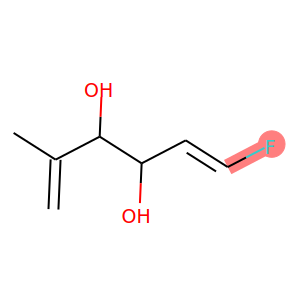

In [104]:
SVG(draw_mol_outlier(smiles, missing_atom, missing_bond))

In [101]:
missing_atom

array([9])

In [102]:
missing_bond

array([8])

In [81]:
mol = Chem.MolFromSmiles(smiles)
molH = Chem.AddHs(mol)

In [82]:
molH.GetNumBonds()

20

In [83]:
smiles

'C=C(C)[C@H](O)[C@H](O)/C=C/F'

In [80]:
missing_atom

array([9])

In [79]:
missing_bond

array([26, 28])

In [100]:
iinput = inputs[0]
missing_bond = np.array(list(set(iinput['bond_indices'][iinput['bond'] == 1])))
missing_atom = np.arange(iinput['n_atom'])[iinput['atom'] == 1]

{8}

In [59]:
missing_bond.size

2

In [58]:
if missing_bond.size == 0:
    print(True)

NameError: name 'missing_atom' is not defined

In [11]:

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model = load_model('model_files/best_model.hdf5', custom_objects=custom_layers)
    
model.summary()

Model: "graphmodel_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bond (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
atom (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
squeeze_1 (Squeeze)             (None,)              0           atom[0][0]                       
                                                                 bond[0][0]                       
__________________________________________________________________________________________________
atom_embedding (Embedding)      (None, 128)          12672       squeeze_1[0][0]       

In [12]:
pred = model.predict_generator(
    ConcatGraphSequence(inputs, batch_size=1, shuffle=False), verbose=0)

In [25]:
bde_df = pd.DataFrame(inputs[0]['bond_indices'], columns=['bond_index'])
bde_df['bde_pred'] = pred
bde_df = bde_df.groupby('bond_index').mean().reset_index()

pred_df = frag_df.merge(bde_df, on=['bond_index'], how='left')
pred_df = pred_df.sort_values('bde_pred').drop_duplicates(
    ['fragment1', 'fragment2']).reset_index()

In [36]:
pred_df['svg'] = pred_df.apply(lambda x: draw_bde(x.molecule, x.bond_index), 1)

0     <IPython.core.display.SVG object>
1     <IPython.core.display.SVG object>
2     <IPython.core.display.SVG object>
3     <IPython.core.display.SVG object>
4     <IPython.core.display.SVG object>
5     <IPython.core.display.SVG object>
6     <IPython.core.display.SVG object>
7     <IPython.core.display.SVG object>
8     <IPython.core.display.SVG object>
9     <IPython.core.display.SVG object>
10    <IPython.core.display.SVG object>
11    <IPython.core.display.SVG object>
12    <IPython.core.display.SVG object>
13    <IPython.core.display.SVG object>
dtype: object

In [32]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def draw_bde(smiles, bond_index, figsize=(300, 300)):
    
    mol = Chem.MolFromSmiles(smiles)
    bond_index = int(bond_index)

    if bond_index >= mol.GetNumBonds():

        molH = Chem.AddHs(mol)
        bond = molH.GetBondWithIdx(bond_index)

        start_atom = mol.GetAtomWithIdx(bond.GetBeginAtomIdx())
        mol = Chem.AddHs(mol, onlyOnAtoms=[start_atom.GetIdx()])
        bond_index = mol.GetNumBonds() - 1

    bond = mol.GetBondWithIdx(bond_index)
    if not mol.GetNumConformers():
        rdDepictor.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(*figsize)
    drawer.SetFontSize(.6)
    drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=[bond_index,])

    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()

    svg = svg.replace('svg:', '').replace(':svg', '')
    
    return SVG(svg)

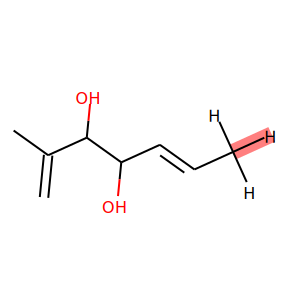

In [33]:
draw_bde(smiles, 21)

In [34]:
def draw_mol(smiles, figsize=(300, 300)):
    
    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(*figsize)
    drawer.SetFontSize(.6)
    drawer.DrawMolecule(mol)

    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()

    svg = svg.replace('svg:', '').replace(':svg', '')
    
    return SVG(svg)

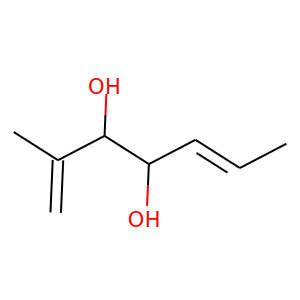

In [35]:
draw_mol(smiles)